In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# IMPORTS

In [ ]:

#IMPORTS
import string
from collections import Counter
import datetime as dt
from numpy import array
import numpy as np
import pickle
from pickle import load, dump

import keras

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

from keras.models import Model
from keras.preprocessing import image
from keras import Input
from keras.layers import Dropout, Dense, Embedding, LSTM,InputLayer
from keras.layers.merge import add
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import keras.backend as K
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, Image

# Utils

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [ ]:
# Path to root dataset folder on mounted drive
project_root_path = "gdrive/MyDrive/"
dataset_root_path = project_root_path + "Dataset/"
models_root_path = project_root_path + "Models/"
variables_root_path = project_root_path + "Variables/"

In [ ]:
# Function to read data
def read_content(filepath, encode = None):
    lines = []
    with open(filepath, encoding = encode) as file:
        content = file.read()
        lines = content.split("\n")
    return lines[:-1]   # Removing last blank line

# Function to dump data to .pkl file at filepath
def dumpData(filepath, data):
    with open(filepath, "wb") as encoded_pickle:
        dump(data, encoded_pickle)

# Function to load data from .pkl file at filepath
def loadData(filepath):
    with open(filepath, "rb") as encoded_pickle:
        return load(encoded_pickle)

# EXTRACTING TEXT DATA AND PREPROCESSING

In [ ]:
# STEP: EXTRACTING DATA
filepath = dataset_root_path + "Flickr8k_text/Flickr8k.token.txt"
lines = read_content(filepath)

In [ ]:
# STEP: SAVING DATA IN A DICTIONARY FOR TIME EFFICIENCY PURPOSES
def make_dict(text):
    # Dictionary with key as the image id
    img_cpt_dict = dict()

    for line in text:   # Each line format <image_id>.jpg#<num>\t<image_caption>
        [img, img_caption] = line.split("\t")
        img_id = img.split(".")[0]
        if (img_id not in img_cpt_dict.keys()):
            img_cpt_dict[img_id] = list()
        img_cpt_dict[img_id].append(img_caption)
    return img_cpt_dict

img_cpt_dict = make_dict(lines)
print("Number of images in Dataset:", len(img_cpt_dict))

Number of images in Dataset: 8092


In [ ]:
# STEP: PREPROCESSING
# Lowercasing & Removing punctuations and special tokens like #,$,@
def preprocess_captions(dct):
    # prepare translation table for removing punctuation
    table = str.maketrans("", "", string.punctuation)
    for captions in dct.values():
        for i in range(len(captions)):
            caption = captions[i]
            # tokenize
            words = caption.split()
            # convert to lower case
            words = [word.lower() for word in words]
            # remove punctuation from each token
            words = [word.translate(table) for word in words]
            # remove hanging 's' and 'a'
            words = [word for word in words if len(word) > 1]
            # remove tokens with numbers in them
            words = [word for word in words if word.isalpha()]
            # store as string
            captions[i] = " ".join(words)

preprocess_captions(img_cpt_dict)
dumpData(variables_root_path + "img_cpt_dict.pkl", img_cpt_dict)

In [ ]:
img_cpt_dict = loadData(variables_root_path + "img_cpt_dict.pkl")

#LOADING TRAINING SET

In [ ]:
# STEP: EXTRACTING DATA
filepath = dataset_root_path + "Flickr8k_text/Flickr_8k.trainImages.txt"
lines = read_content(filepath)

In [ ]:
# STEP: SAVING DATA IN A LIST
def make_list(text):
    img_list = list()
    for line in text:
        [img_title, ext] = line.split(".")
        img_list.append(img_title)
    return img_list

train = make_list(lines)

In [ ]:
# STEP: SAVING IMAGE-CAPTIONS IN TRAIN DATASET
def start_end_token(dataset):
    new_dataset = dict()
    max_caption_length = 0
    for img_title, captions in img_cpt_dict.items():
        if (img_title in dataset and (img_title not in new_dataset.keys())):
            new_dataset[img_title] = list()
            for caption in captions:
                # wrap caption in tokens
                new_caption = "startseq " + caption + " endseq"
                new_dataset[img_title].append(new_caption)
                max_caption_length = max(max_caption_length, len(new_caption.split()))
    return (new_dataset, max_caption_length)

train_dataset, max_caption_length = start_end_token(train)
print("Length of Train Dataset:", len(train_dataset))
print("Maximum Caption Length:", max_caption_length)
dumpData(variables_root_path + "train_dataset.pkl", train_dataset)

Length of Train Dataset: 6000
Maximum Caption Length: 34


In [ ]:
train_dataset = loadData(variables_root_path + "train_dataset.pkl")

# LOADING CROSS VALIDATION(OR DEVELOPMENT) SET

In [ ]:
# STEP: EXTRACTING DATA
filepath = dataset_root_path + "Flickr8k_text/Flickr_8k.devImages.txt"
lines = read_content(filepath)

In [ ]:
# STEP: SAVING DATA IN A LIST
dev = make_list(lines)

In [ ]:
# STEP: SAVING IMAGE-CAPTIONS IN DEV DATASET
dev_dataset, stuff = start_end_token(dev)
print("Length of Dev Dataset:", len(dev_dataset))
dumpData(variables_root_path + "dev_dataset.pkl", dev_dataset)

Length of Dev Dataset: 1000


In [ ]:
dev_dataset = loadData(variables_root_path + "dev_dataset.pkl")

#LOADING TESTING SET

In [ ]:
# STEP: EXTRACTING DATA
filepath = dataset_root_path + "Flickr8k_text/Flickr_8k.testImages.txt"
lines = read_content(filepath)

In [ ]:
# STEP: SAVING DATA IN A LIST
test = make_list(lines)

In [ ]:
STEP: SAVING IMAGE-CAPTIONS IN TESt DATASET
test_dataset, stuff = start_end_token(test)
print("Length of Test Dataset:", len(test_dataset))
dumpData(variables_root_path + "test_dataset.pkl", test_dataset)

In [ ]:
test_dataset = loadData(variables_root_path + "test_dataset.pkl")

#CONSTRUCTING VOCABULARY FROM CAPTIONS

In [ ]:
def create_vocabulary(dct):
    
    vocab={'startseq','endseq'}
    for captions in dct.values():
        for caption in captions:
            for word in caption.split():
                vocab.add(word)
    return vocab

vocab = create_vocabulary(img_cpt_dict)
print("Number of different words in vocabulary:", len(vocab))
dumpData(variables_root_path + "vocab.pkl", vocab)

In [ ]:
vocab= loadData(variables_root_path + "vocab.pkl")

#CONSTRUCTING MOST PROBABLE VOCABULARY FROM ALL TRAIN WORDS

In [ ]:
def most_probable_vocab(dct, threshold = 8):
    probable_vocab_counts = dict()
    for captions in dct.values():
        for caption in captions:
            for word in caption.split():
                if (word not in probable_vocab_counts.keys()):
                    probable_vocab_counts[word] = 0
                else:
                    probable_vocab_counts[word] += 1
  
    return {word for word in probable_vocab_counts if probable_vocab_counts[word] >= threshold}

most_probable_vocabulary = most_probable_vocab(train_dataset)
vocabulary_size = len(most_probable_vocabulary)
print("Most Probable Vocabulary Size:", vocabulary_size)
dumpData(variables_root_path + "most_probable_vocabulary.pkl", most_probable_vocabulary)
dumpData(variables_root_path + "vocabulary_size.pkl", vocabulary_size)

In [ ]:
most_probable_vocabulary= loadData(variables_root_path + "most_probable_vocabulary.pkl")
vocabulary_size= loadData(variables_root_path + "vocabulary_size.pkl")

In [ ]:
vocabulary_size

1762

###TO GET INPUT VECTOR X FROM IMAGES WE USE TRANSFER LEARNING THROUGH Inception MODEL TRAINED ON 1000 DIFFERENT CLASSES OF IMAGES

In [ ]:
def image_id(data):
  
  img_id=[]
  for id in data.keys():
    img_id.append(id)

  return img_id

In [ ]:
train_id= image_id(train_dataset)
train_id[0]

In [ ]:
def extract_features(train_id):
    
  model = InceptionV3(weights="imagenet")         #Loading model
  
  # re-structure the model
  model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

  print(model.summary())
  
  #To store the feature vector of the image
  features={}
  
  for id in train_id:
     
    image = load_img(dataset_root_path + "/Flickr8k_Dataset/Flicker8k_Dataset/"+ id + '.jpg', target_size=(299, 299))
    # convert the image pixels to a numpy array
    image = img_to_array(image)

    image = np.expand_dims(image, axis=0)     
    
    # prepare the image for the Inception model
    image = preprocess_input(image)
            
    # get the features
    feature = model.predict(image, verbose=0)


    feature = np.reshape(feature, feature.shape[1])
   
    # store feature
    features[id] = feature

  return features

In [ ]:
features=extract_features(train_id)

In [ ]:
dev_id= image_id(dev_dataset)
len(dev_id)

In [ ]:
def extract_features(dev_id):
    
  model = InceptionV3(weights="imagenet")         #Loading model
  
  # re-structure the model
  model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

  print(model.summary())
  
  #To store the feature vector of the image
  features={}
  
  for id in dev_id:
     
    image = load_img(dataset_root_path + "/Flickr8k_Dataset/Flicker8k_Dataset/"+ id + '.jpg', target_size=(299, 299))
    # convert the image pixels to a numpy array
    image = img_to_array(image)

    image = np.expand_dims(image, axis=0)     
    
    # prepare the image for the Inception model
    image = preprocess_input(image)
            
    # get the features
    feature = model.predict(image, verbose=0)


    feature = np.reshape(feature, feature.shape[1])
   
    # store feature
    features[id] = feature

  return features


In [ ]:
dev_features=extract_features(dev_id)

In [ ]:
test_id= image_id(test_dataset)
len(test_id)

1000

In [ ]:
def extract_features(test_id):
    
  model = InceptionV3(weights="imagenet")         #Loading model
  
  # re-structure the model
  model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

  print(model.summary())
  
  #To store the feature vector of the image
  features={}
  
  for id in test_id:
     
    image = load_img(dataset_root_path + "/Flickr8k_Dataset/Flicker8k_Dataset/"+ id + '.jpg', target_size=(299, 299))
    # convert the image pixels to a numpy array
    image = img_to_array(image)

    image = np.expand_dims(image, axis=0)     
    
    # prepare the image for the Inception model
    image = preprocess_input(image)
            
    # get the features
    feature = model.predict(image, verbose=0)


    feature = np.reshape(feature, feature.shape[1])
   
    # store feature
    features[id] = feature

  return features

In [ ]:
test_features=extract_features(test_id)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [ ]:
with open("gdrive/MyDrive/traindata_images.pkl", "wb") as encoded_pickle:
    pickle.dump(features, encoded_pickle)

In [ ]:
with open("gdrive/MyDrive/devdata_images.pkl", "wb") as encoded_pickle:
    pickle.dump(dev_features, encoded_pickle)

In [ ]:
with open("gdrive/MyDrive/testdata_images.pkl", "wb") as encoded_pickle:
    pickle.dump(test_features, encoded_pickle)

In [ ]:
with open('gdrive/MyDrive/traindata_images.pkl', 'rb') as f:
    train_features = pickle.load(f)

In [ ]:
with open('gdrive/MyDrive/devdata_images.pkl', 'rb') as f:
    dev_features = pickle.load(f)

In [ ]:
with open('gdrive/MyDrive/testdata_images.pkl', 'rb') as f:
    test_features = pickle.load(f)

In [ ]:
# USEFUL DICTIONARIES
index_to_word = {}
word_to_index = {}
for index, word in enumerate(most_probable_vocabulary):
    index_to_word[index] = word
    word_to_index[word] = index



dumpData(variables_root_path + "index_to_word.pkl", index_to_word)
dumpData(variables_root_path + "word_to_index.pkl", word_to_index)

In [ ]:
index_to_word = loadData(variables_root_path + "index_to_word.pkl")
word_to_index= loadData(variables_root_path + "word_to_index.pkl")

In [ ]:
def caption_to_tensor(list_of_words):
  
  tensor= []
  for w in list_of_words:
    tensor.append(word_to_index[w])
  return tensor

In [ ]:
# data generator, intended to be used in a call to model.fit_generator()
# create sequences of images, input sequences and output words for an image
def data_generator(batch_size,data,features,vocabulary,max_length):
  
  index=0
  curr_batch=[]

  while True:
    
    for id,caption_list in data.items():
      
      index+=1
      feature_vector = features[id]
      
      for caption in caption_list:
        cpt = [word for word in caption.split(' ') if word in vocabulary]
        for i in range(1,len(cpt)):
          
          input = cpt[:i]
          output = cpt[i]
          curr_batch.append([feature_vector,input,output])
        
      if index == batch_size:
      
        image_input,caption_input,outputs = [],[],[]
      
        for batch_elem in curr_batch:
        
          tensor = caption_to_tensor(batch_elem[1])
          pad = [0] * (max_length - len(tensor))
          input_tensor = tensor + pad

          output_tensor = caption_to_tensor([batch_elem[2]])
          output = to_categorical(output_tensor, num_classes=len(vocabulary))[0]

          image_input.append(batch_elem[0])
          caption_input.append(input_tensor)
          outputs.append(output)

        yield ([np.array(image_input), np.array(caption_input)], np.array(outputs))
        index=0
        curr_batch=[]

In [ ]:
# RUN THIS CELL ONLY ONCE #

# WORD EMBEDDINGS, MAPPING EVERY WORD OF OUR MOST PROBABALE VOCABULARY TO 200 DIMENSION VECTOR, FOR THAT WE WILL BE USING GLOVE
embeddings = {}
filepath = dataset_root_path + "glove.6B/glove.6B.200d.txt"

lines = read_content(filepath)

for line in lines:
  
    word_and_vector = line.split()
    word = word_and_vector[0]
    vector = word_and_vector[1:]
    vector = np.asarray(vector, dtype = "float32")
    embeddings[word] = vector


In [ ]:
embedding_dim = 200
embeddings_matrix = np.zeros((vocabulary_size, embedding_dim))
for word, index in word_to_index.items():
    vector = embeddings.get(word)
    if (vector is not None):
        # words not found in embedding index will be all-zeros.
        embeddings_matrix[index] = vector

In [ ]:
dumpData(variables_root_path + "embeddings_matrix.pkl", embeddings_matrix)
dumpData(variables_root_path + "embedding_dim.pkl", embedding_dim)

In [ ]:
embeddings_matrix = loadData(variables_root_path + "embeddings_matrix.pkl")
embedding_dim= loadData(variables_root_path + "embedding_dim.pkl")

In [ ]:
# DEFINING THE LAYERS OF THE MODEL
def model_definition(vocab_size, max_length, embedding_dimension):
  
  image_model = keras.Sequential(
  [
        InputLayer(input_shape=(2048,)),
        Dropout(0.5),
        Dense(256,activation='relu')    
  ])
  caption_model = keras.Sequential(
  [
        InputLayer(input_shape=(max_length,)),
        Embedding(vocab_size,embedding_dim,mask_zero=True),
        Dropout(0.5),
        LSTM(256)
  ])

  decoder1 = add([image_model.layers[-1].output,caption_model.layers[-1].output])
  decoder2 = Dense(256, activation='relu')(decoder1)
  output = Dense(vocab_size, activation='softmax')(decoder2)
  
  model = Model(inputs=[image_model.inputs, caption_model.inputs], outputs=output)

  # summarize model
  print(model.summary())
  return model

model = model_definition(vocabulary_size, max_caption_length, embedding_dim)

In [ ]:
#No training on embedding layer since we use pretrained model like GLove
model.layers[2].set_weights([embeddings_matrix])
model.layers[2].trainable = False

#Model optimizer and loss function
model.compile(loss = "categorical_crossentropy", optimizer = "adam",metrics=['accuracy'])

In [ ]:
#Training session 1
epochs = 20
batch_size = 3
steps = len(train_dataset) // batch_size

In [ ]:
#training session 1
loss,accuracy =[],[]

for i in range(epochs):
    generator = data_generator(batch_size,train_dataset, train_features, most_probable_vocabulary,max_caption_length)
    hist= model.fit(generator, epochs = 1, steps_per_epoch = steps, verbose = 1)
    loss_epoch = hist.history["loss"]
    accuracy_epoch = hist.history["accuracy"]
    loss.append(loss_epoch)
    accuracy.append(accuracy_epoch)
    model.save(models_root_path + "inception_model_final" + str(i))

In [ ]:
loaded_model = keras.models.load_model(models_root_path + "inception_model_final19")

In [ ]:
# Training session 2
K.set_value(loaded_model.optimizer.lr, 0.0005)
epochs = 10
batch_size = 6
steps = len(train_dataset) // batch_size

In [ ]:
# TRAINING SESSION 2

acc=[]
lss=[]



for i in range(epochs):
    generator = data_generator(batch_size,train_dataset, train_features, most_probable_vocabulary,34)
    hist= loaded_model.fit(generator, epochs = 1, steps_per_epoch = steps, verbose = 1)
    loss_epoch = hist.history["loss"]
    accuracy_epoch = hist.history["accuracy"]
    lss.append(loss_epoch)
    acc.append(accuracy_epoch)
    loaded_model.save(models_root_path + "inception_model_final_after20" + str(i+20))

In [ ]:
# TWEAKED THE PARAMETERS(LEARNING RATE DECAY)
# HYPERPARAMETERS OF TRAINING SESSION 3
# NOTE: LEARNING RATE IS CHANGED TO 0.0003
K.set_value(loaded_model.optimizer.lr, 0.0003)
epochs = 5
batch_size = 6
steps = len(train_dataset) // batch_size
# NOTE: SIZE OF TRAIN DATASET IS 6000

In [ ]:
# training session 3


for i in range(epochs):
    generator = data_generator(batch_size,train_dataset, train_features, most_probable_vocabulary,34)
    hist= loaded_model.fit(generator, epochs = 1, steps_per_epoch = steps, verbose = 1)
    loss_epoch = hist.history["loss"]
    accuracy_epoch = hist.history["accuracy"]
    lss.append(loss_epoch)
    acc.append(accuracy_epoch)
    loaded_model.save(models_root_path + "inception_model_final_after20" + str(i+30))

In [ ]:
load_saved_final_model = keras.models.load_model(models_root_path + "inception_model_final_after2034")


In [ ]:
from IPython.display import display, Image

In [ ]:
def predict(features):
  
    partial_caption = "startseq"
    for i in range(max_caption_length):
        # integer encode input sequence
        seq = [word_to_index[word] for word in partial_caption.split() if word in word_to_index]
        # pad input
        seq = pad_sequences([seq], maxlen = max_caption_length)
        # predict next word
        model_softMax_output = load_saved_final_model.predict([feature_vec, seq], verbose = 0)
        # convert probability to integer
        word_index = np.argmax(model_softMax_output)
        # map integer to word
        word = index_to_word[word_index]
        partial_caption += " " + word
        if (word == "endseq"):
            break
    final_caption = partial_caption.split()[1:-1]
    final_caption = " ".join(final_caption)
    return final_caption

In [ ]:
print_loss = loss[0:20] + lss
print_accuracy = accuracy[0:20] + acc

Inception Model
1357753846_6185e26040


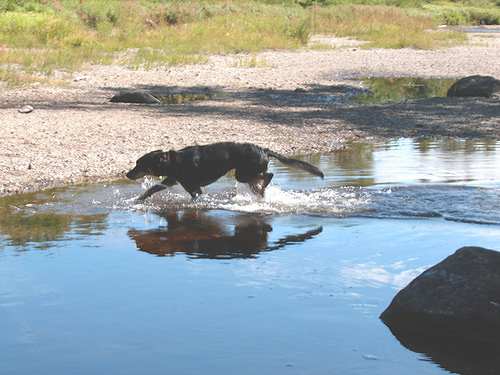

prediction: dog is running through the water
Ground Truth: big black dog runs through the water near the shore
Ground Truth: black dog crossing stream
Ground Truth: black dog is walking through stream of water
Ground Truth: black dog runs through the water
Ground Truth: black dog walks through some water


In [ ]:
# OBSERVATION OF PERFORMANCE ON RANDOM IMAGES FROM DEV DATASET
key = "1357753846_6185e26040"
print("Inception Model")
print(key)
feature_vec = train_features[key].reshape((1, 2048))
display(Image(filename = dataset_root_path + "Flickr8k_Dataset/Flicker8k_Dataset/" + key + ".jpg"))
print("prediction: {}".format(predict(feature_vec)))
for caption in train_dataset[key]:
    caption = " ".join(caption.split()[1:-1])
    print("Ground Truth: {}".format(caption))

Inception Model
1461329041_c623b06e5b


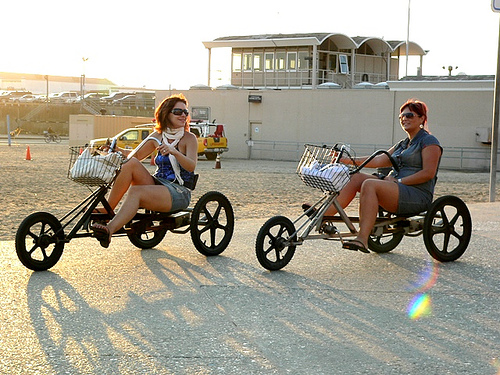

prediction: two girls are riding wheeler
Ground Truth: the two ladies are riding bicycles near the beach
Ground Truth: two women in summer wear ride beach cruiser tricycles on the concrete near the beach
Ground Truth: two women on low riding threewheeled vehicles with baskets
Ground Truth: two women ride their three wheelers
Ground Truth: two women riding tricycles


In [ ]:
# OBSERVATION OF PERFORMANCE ON RANDOM IMAGES FROM DEV DATASET
key =  list(train_dataset.keys())[np.random.randint(0, 1000)]
print("Inception Model")
print(key)
feature_vec = train_features[key].reshape((1, 2048))
display(Image(filename = dataset_root_path + "Flickr8k_Dataset/Flicker8k_Dataset/" + key + ".jpg"))
print("prediction: {}".format(predict(feature_vec)))
for caption in train_dataset[key]:
    caption = " ".join(caption.split()[1:-1])
    print("Ground Truth: {}".format(caption))

Inception Model
1795151944_d69b82f942


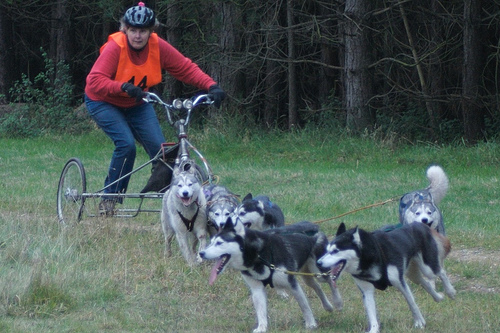

prediction: pack of dogs are running through the grass
Ground Truth: team of dogs and woman following on bike
Ground Truth: woman is riding three wheeler bicycle behind pack of dogs
Ground Truth: woman on trike and team of dogs
Ground Truth: six huskies are pulling three wheeled vehicle through the grass
Ground Truth: woman being pulled on large tricycle by several sled dogs


In [ ]:
# OBSERVATION OF PERFORMANCE ON RANDOM IMAGES FROM DEV DATASET
key =  list(train_dataset.keys())[np.random.randint(0, 1000)]
print("Inception Model")
print(key)
feature_vec = train_features[key].reshape((1, 2048))
display(Image(filename = dataset_root_path + "Flickr8k_Dataset/Flicker8k_Dataset/" + key + ".jpg"))
print("prediction: {}".format(predict(feature_vec)))
for caption in train_dataset[key]:
    caption = " ".join(caption.split()[1:-1])
    print("Ground Truth: {}".format(caption))

Inception Model
1227655020_b11a1bb112


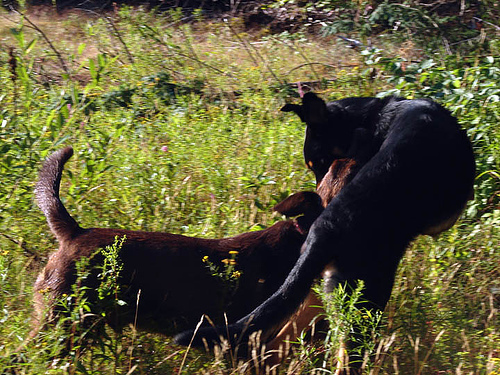

prediction: two dogs are running in field
Ground Truth: black dog and brown dog playing in tall weeds
Ground Truth: brown dog and black dog are standing against each other in some grass
Ground Truth: two dogs are playing outside in field
Ground Truth: two dogs play in tall grass
Ground Truth: two dogs wrestle together in the long grass


In [ ]:
# OBSERVATION OF PERFORMANCE ON RANDOM IMAGES FROM DEV DATASET
key =  list(train_dataset.keys())[np.random.randint(0, 1000)]
print("Inception Model")
print(key)
feature_vec = train_features[key].reshape((1, 2048))
display(Image(filename = dataset_root_path + "Flickr8k_Dataset/Flicker8k_Dataset/" + key + ".jpg"))
print("prediction: {}".format(predict(feature_vec)))
for caption in train_dataset[key]:
    caption = " ".join(caption.split()[1:-1])
    print("Ground Truth: {}".format(caption))

Inception Model
1662261486_db967930de


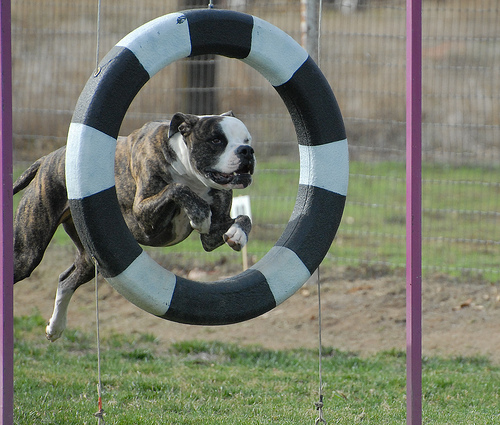

prediction: black and white dog is jumping over hurdle
Ground Truth: black and white dog is jumping through black and white hoop
Ground Truth: black and white dog jumps through black and white hoop
Ground Truth: brown and white dog jumping through black and white hoop
Ground Truth: dog jumping through black and white hoop
Ground Truth: dog jumping through ring


In [ ]:
# OBSERVATION OF PERFORMANCE ON RANDOM IMAGES FROM DEV DATASET
key =  "1662261486_db967930de"
print("Inception Model")
print(key)
feature_vec = train_features[key].reshape((1, 2048))
display(Image(filename = dataset_root_path + "Flickr8k_Dataset/Flicker8k_Dataset/" + key + ".jpg"))
print("prediction: {}".format(predict(feature_vec)))
for caption in train_dataset[key]:
    caption = " ".join(caption.split()[1:-1])
    print("Ground Truth: {}".format(caption))

Inception Model
1536597926_c2e1bc2379


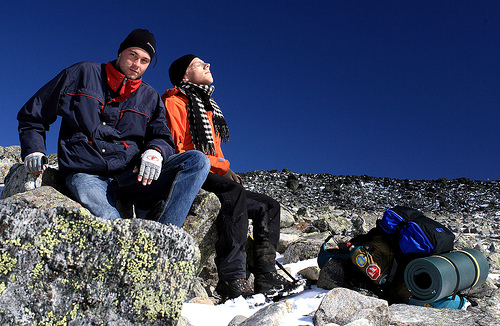

prediction: man in red jacket is standing on top of mountain
Ground Truth: two hikers rest on snowcovered mountain
Ground Truth: two men and backpack
Ground Truth: two men pause on rock while hiking in barren terrain
Ground Truth: two men resting uptop snowy mountain
Ground Truth: two people sitting on rocks and pack at their feet


In [ ]:
# OBSERVATION OF PERFORMANCE ON RANDOM IMAGES FROM DEV DATASET
key =  "1536597926_c2e1bc2379"
print("Inception Model")
print(key)
feature_vec = train_features[key].reshape((1, 2048))
display(Image(filename = dataset_root_path + "Flickr8k_Dataset/Flicker8k_Dataset/" + key + ".jpg"))
print("prediction: {}".format(predict(feature_vec)))
for caption in train_dataset[key]:
    caption = " ".join(caption.split()[1:-1])
    print("Ground Truth: {}".format(caption))

Inception Model
2086532897_b8714f2237


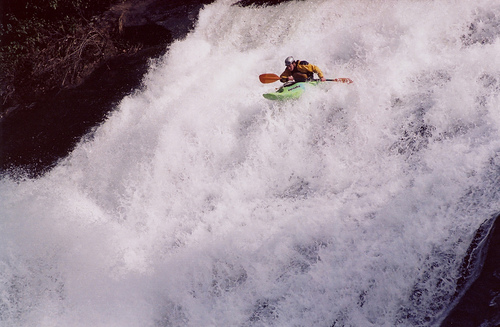

prediction: man in kayak is riding through rough waters
Ground Truth: kayaker falling down waterfall
Ground Truth: man is kayaking down waterfall
Ground Truth: man on kayak coming down raging waterfall
Ground Truth: person is on small boat and going down some very strong water currents
Ground Truth: white water rafter goes through rough spot


In [ ]:
# OBSERVATION OF PERFORMANCE ON RANDOM IMAGES FROM DEV DATASET
key =  "2086532897_b8714f2237"
print("Inception Model")
print(key)
feature_vec = train_features[key].reshape((1, 2048))
display(Image(filename = dataset_root_path + "Flickr8k_Dataset/Flicker8k_Dataset/" + key + ".jpg"))
print("prediction: {}".format(predict(feature_vec)))
for caption in train_dataset[key]:
    caption = " ".join(caption.split()[1:-1])
    print("Ground Truth: {}".format(caption))




Inception Model
1351315701_6580b51c41


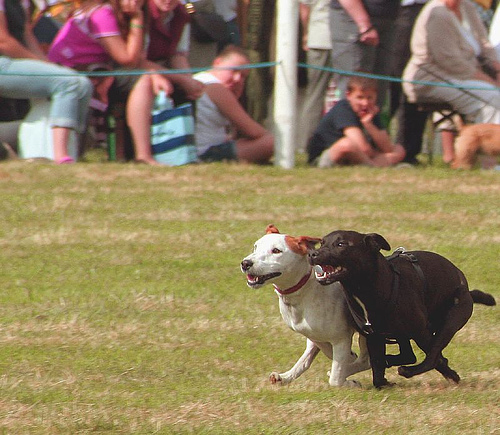

prediction: two dogs are running through field
Ground Truth: black and white dog are running on the grass
Ground Truth: black dog and white dog race in grassy field while spectators look on
Ground Truth: white dog and black dog running side by side on the grass while onlookers watch
Ground Truth: two dogs pitbull and black labrador run side by side
Ground Truth: two dogs racing in field with people looking on


In [ ]:
key ="1351315701_6580b51c41"
print("Inception Model")
print(key)
feature_vec = train_features[key].reshape((1, 2048))
display(Image(filename = dataset_root_path + "Flickr8k_Dataset/Flicker8k_Dataset/" + key + ".jpg"))
print("prediction: {}".format(predict(feature_vec)))
for caption in train_dataset[key]:
    caption = " ".join(caption.split()[1:-1])
    print("Ground Truth: {}".format(caption))

Inception Model
1465666502_de289b3b9c


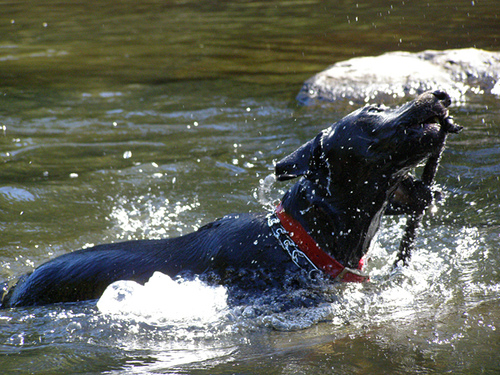

prediction: black dog is swimming in the water
Ground Truth: black dog is swimming in green water with something in its mouth
Ground Truth: black dog playing in river
Ground Truth: black dog wearing red collar is dragging rope though river
Ground Truth: black dog with red collar retrieving stick from deep water
Ground Truth: the black dog emerges from the water having collected an object in his teeth


In [ ]:
key = list(train_dataset.keys())[np.random.randint(0, 1000)]
print("Inception Model")
print(key)
feature_vec = train_features[key].reshape((1, 2048))
display(Image(filename = dataset_root_path + "Flickr8k_Dataset/Flicker8k_Dataset/" + key + ".jpg"))
print("prediction: {}".format(predict(feature_vec)))
for caption in train_dataset[key]:
    caption = " ".join(caption.split()[1:-1])
    print("Ground Truth: {}".format(caption))

Inception Model
218342358_1755a9cce1


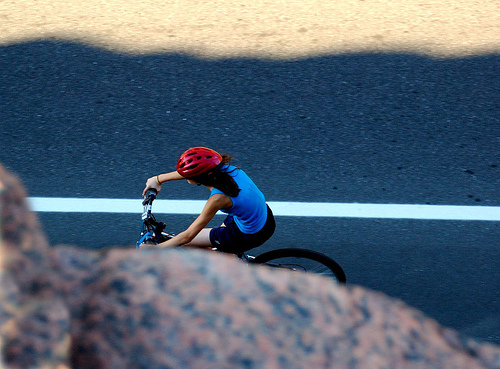

prediction: man in red shirt and helmet is riding bicycle on the street
Ground Truth: cyclist wearing red helmet is riding on the pavement
Ground Truth: girl is riding bike on the street while wearing red helmet
Ground Truth: person on bike wearing red helmet riding down street
Ground Truth: woman wears red helmet and blue shirt as she goes for bike ride in the shade
Ground Truth: person in blue shirt and red helmet riding bike down the road


In [ ]:
key = "218342358_1755a9cce1"
print("Inception Model")
print(key)
feature_vec = train_features[key].reshape((1, 2048))
display(Image(filename = dataset_root_path + "Flickr8k_Dataset/Flicker8k_Dataset/" + key + ".jpg"))
print("prediction: {}".format(predict(feature_vec)))
for caption in train_dataset[key]:
    caption = " ".join(caption.split()[1:-1])
    print("Ground Truth: {}".format(caption))

Inception Model
1569687608_0e3b3ad044


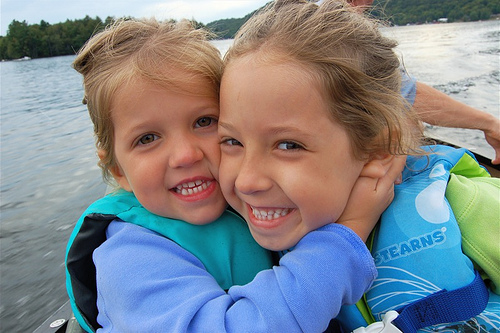

prediction: two girls are sitting on the ground by the water
Ground Truth: two girls are wearing life vests and hugging each other
Ground Truth: two little girls are posing for picture on boat
Ground Truth: two little girls on boat pose for picture together
Ground Truth: two smiling little girls in boat on lake are hugging
Ground Truth: two young fair girls are smiling posing together while they ride in boat wearing floatation vests


In [ ]:
key = "1569687608_0e3b3ad044"
print("Inception Model")
print(key)
feature_vec = train_features[key].reshape((1, 2048))
display(Image(filename = dataset_root_path + "Flickr8k_Dataset/Flicker8k_Dataset/" + key + ".jpg"))
print("prediction: {}".format(predict(feature_vec)))
for caption in train_dataset[key]:
    caption = " ".join(caption.split()[1:-1])
    print("Ground Truth: {}".format(caption))

Inception Model
1143373711_2e90b7b799


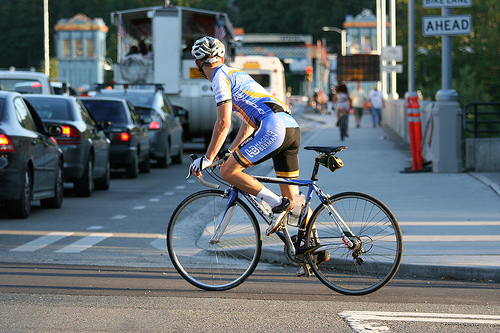

prediction: man in red shirt and jeans is riding unicycle down street
Ground Truth: bicycle rider is crossing street
Ground Truth: bicyclist getting ready to cross street
Ground Truth: biker in spandex riding on busy street
Ground Truth: man in blue and white biking gear rides down busy street
Ground Truth: man wearing helmet riding his bicycle down the street


In [ ]:
key = "1143373711_2e90b7b799"
print("Inception Model")
print(key)
feature_vec = train_features[key].reshape((1, 2048))
display(Image(filename = dataset_root_path + "Flickr8k_Dataset/Flicker8k_Dataset/" + key + ".jpg"))
print("prediction: {}".format(predict(feature_vec)))
for caption in train_dataset[key]:
    caption = " ".join(caption.split()[1:-1])
    print("Ground Truth: {}".format(caption))

Inception Model
1020651753_06077ec457


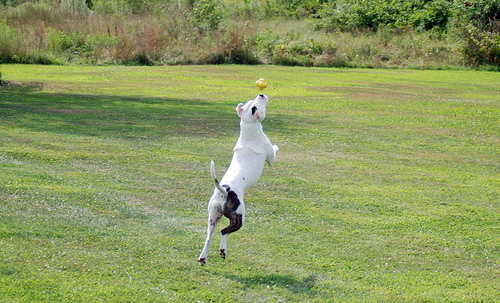

prediction: two dogs are playing with ball in the grass
Ground Truth: black and white dog jumping in the air to get toy
Ground Truth: black and white dog jumps up towards yellow toy
Ground Truth: dog leaps to catch ball in field
Ground Truth: white dog is trying to catch ball in midair over grassy field
Ground Truth: the white dog is playing in green field with yellow toy


In [ ]:
key = list(train_dataset.keys())[np.random.randint(0, 1000)]
print("Inception Model")
print(key)
feature_vec = train_features[key].reshape((1, 2048))
display(Image(filename = dataset_root_path + "Flickr8k_Dataset/Flicker8k_Dataset/" + key + ".jpg"))
print("prediction: {}".format(predict(feature_vec)))
for caption in train_dataset[key]:
    caption = " ".join(caption.split()[1:-1])
    print("Ground Truth: {}".format(caption))

Inception Model
1143882946_1898d2eeb9


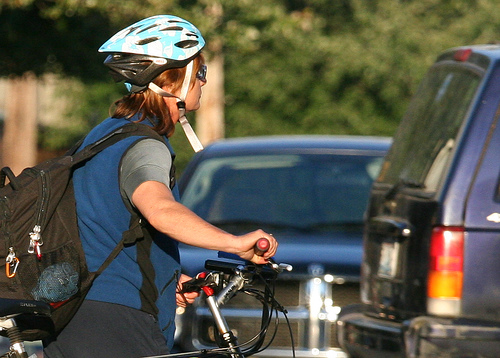

prediction: man in helmet riding gear down street
Ground Truth: lady wearing helmet holding bike
Ground Truth: woman in blue vest and sky blue helmet stands with her bicycle in traffic
Ground Truth: woman in helmet rides her bike behind car
Ground Truth: woman with helmet and backpack walks next to her bike
Ground Truth: women with bike and helmet wait for traffic


In [ ]:
key = "1143882946_1898d2eeb9"
print("Inception Model")
print(key)
feature_vec = train_features[key].reshape((1, 2048))
display(Image(filename = dataset_root_path + "Flickr8k_Dataset/Flicker8k_Dataset/" + key + ".jpg"))
print("prediction: {}".format(predict(feature_vec)))
for caption in train_dataset[key]:
    caption = " ".join(caption.split()[1:-1])
    print("Ground Truth: {}".format(caption))

Inception Model
1771490732_0ab5f029ac


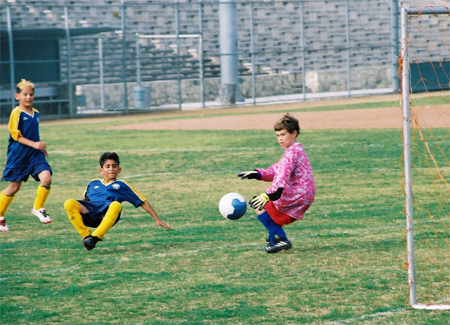

prediction: two boys playing soccer on field
Ground Truth: three boys playing soccer in field
Ground Truth: three boys playing soccer
Ground Truth: two boys in blue and yellow uniforms play soccer with boy in pink printed uniform
Ground Truth: two teammates attempt to convert soccer goal past the goalie
Ground Truth: uniformed children playing soccer


In [ ]:
# OBSERVATION OF PERFORMANCE ON RANDOM IMAGES FROM DEV DATASET
key = "1771490732_0ab5f029ac"
print("Inception Model")
print(key)
feature_vec = train_features[key].reshape((1, 2048))
display(Image(filename = dataset_root_path + "Flickr8k_Dataset/Flicker8k_Dataset/" + key + ".jpg"))
print("prediction: {}".format(predict(feature_vec)))
for caption in train_dataset[key]:
    caption = " ".join(caption.split()[1:-1])
    print("Ground Truth: {}".format(caption))

Inception Model
1273001772_1585562051


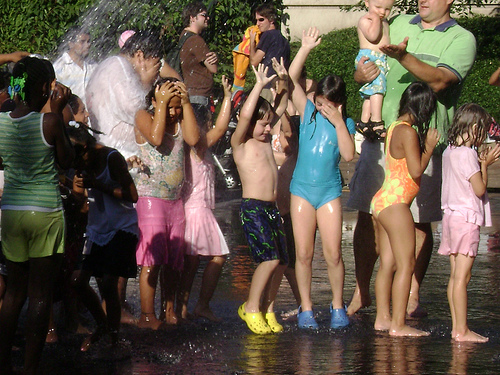

prediction: group of children in the water
Ground Truth: about kids and few adults get splashed by an off camera source
Ground Truth: group of children are in water fountain
Ground Truth: group of children standing in shallow pool of water
Ground Truth: group of young kids play in the water on sunny day
Ground Truth: children and adults play with sprinkler


In [ ]:
key = "1273001772_1585562051"
print("Inception Model")
print(key)
feature_vec = train_features[key].reshape((1, 2048))
display(Image(filename = dataset_root_path + "Flickr8k_Dataset/Flicker8k_Dataset/" + key + ".jpg"))
print("prediction: {}".format(predict(feature_vec)))
for caption in train_dataset[key]:
    caption = " ".join(caption.split()[1:-1])
    print("Ground Truth: {}".format(caption))

Inception Model
2053441349_a98b5fc742


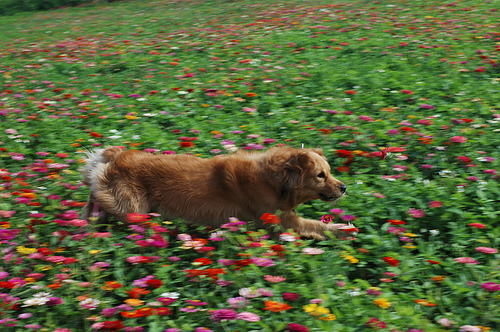

prediction: brown dog is running through the grass
Ground Truth: dog in field of colorful flowers
Ground Truth: large brown dog is running through field of flowers
Ground Truth: tan dog walks through field of colorful flowers
Ground Truth: dog runs through field of flowers
Ground Truth: the brown dog walks through the flowers


In [ ]:
# OBSERVATION OF PERFORMANCE ON RANDOM IMAGES FROM DEV DATASET
key = "2053441349_a98b5fc742"
print("Inception Model")
print(key)
feature_vec = train_features[key].reshape((1, 2048))
display(Image(filename = dataset_root_path + "Flickr8k_Dataset/Flicker8k_Dataset/" + key + ".jpg"))
print("prediction: {}".format(predict(feature_vec)))
for caption in train_dataset[key]:
    caption = " ".join(caption.split()[1:-1])
    print("Ground Truth: {}".format(caption))

Inception Model
2181846120_3744ca3942


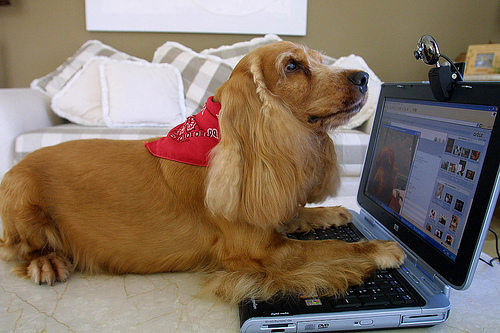

prediction: brown dog is biting the ear of brown dog
Ground Truth: brown dog appears to be operating computer
Ground Truth: brown dog is resting its paws on laptop keyboard
Ground Truth: dog sits with its paws on laptop computer
Ground Truth: dog with red bandanna has its paws on laptop keyboard and is looking up
Ground Truth: the brown dog with red bandanna is sitting with its paws up on the computer


In [ ]:
# OBSERVATION OF PERFORMANCE ON RANDOM IMAGES FROM DEV DATASET
key = "2181846120_3744ca3942"
print("Inception Model")
print(key)
feature_vec = train_features[key].reshape((1, 2048))
display(Image(filename = dataset_root_path + "Flickr8k_Dataset/Flicker8k_Dataset/" + key + ".jpg"))
print("prediction: {}".format(predict(feature_vec)))
for caption in train_dataset[key]:
    caption = " ".join(caption.split()[1:-1])
    print("Ground Truth: {}".format(caption))

TESTING ON DEV SET

Inception Model
3183875944_b2be694e06


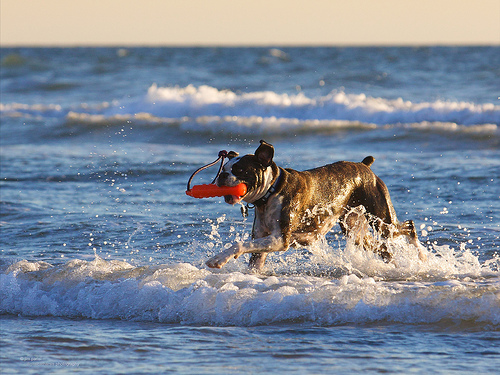

Prediction: black dog is running through the water

Actual Description: brown dog is bringing back buoy from the ocean
Actual Description: brown dog is running in the ocean whilst carrying an orange object in its mouth
Actual Description: dog is running out of the ocean with an orange floating toy in its mouth
Actual Description: dog running through the water with toy at the beach
Actual Description: wellmuscled dog retrieves an orange toy from the surf


In [ ]:
# OBSERVATION OF PERFORMANCE ON RANDOM IMAGES FROM DEV DATASET
key = "3183875944_b2be694e06"
print("Inception Model")
print(key)
feature_vec = dev_features[key].reshape((1, 2048))
display(Image(filename = dataset_root_path + "Flickr8k_Dataset/Flicker8k_Dataset/" + key + ".jpg"))
print("Prediction: {}".format(predict(feature_vec)))
print()
for caption in dev_dataset[key]:
    caption = " ".join(caption.split()[1:-1])
    print("Actual Description: {}".format(caption))

Inception Model
2907073768_08fd7bdf60


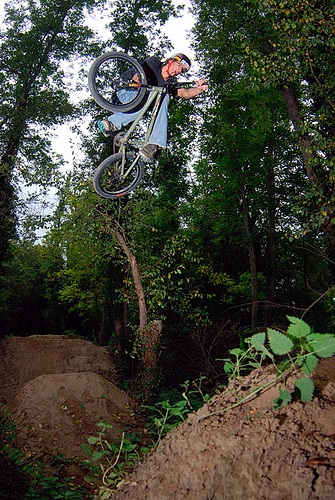

Prediction: man in red shirt is riding bicycle on dirt path

Actual Description: biker jumping extremely high
Actual Description: guy flipped over upside down on bicycle
Actual Description: man rides off of jump and does trick in air
Actual Description: an extreme mountain biker making leap across rough terrain in the woods
Actual Description: the bmx rider wearing black helmet gets air off of jump


In [ ]:
# OBSERVATION OF PERFORMANCE ON RANDOM IMAGES FROM DEV DATASET
key = list(dev_dataset.keys())[np.random.randint(0, 1000)]
print("Inception Model")
print(key)
feature_vec = dev_features[key].reshape((1, 2048))
display(Image(filename = dataset_root_path + "Flickr8k_Dataset/Flicker8k_Dataset/" + key + ".jpg"))
print("Prediction: {}".format(predict(feature_vec)))
print()
for caption in dev_dataset[key]:
    caption = " ".join(caption.split()[1:-1])
    print("Actual Description: {}".format(caption))

Inception Model
634891010_9fa189effb


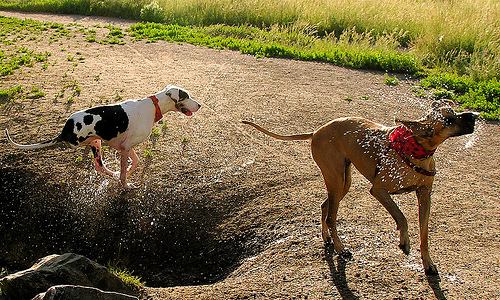

Prediction: two dogs are playing with each other in the grass

Actual Description: black and white dog jumping out of the water and brown dog shaking off
Actual Description: brown dog and black and white dog stand beside hole in the dirt
Actual Description: three legged black and white dog running behind brown dog with red bandanna
Actual Description: two dogs are shaking themselves dry on the path next to the water
Actual Description: two dogs are shaking water off


In [ ]:
key = "634891010_9fa189effb"
print("Inception Model")
print(key)
feature_vec = dev_features[key].reshape((1, 2048))
display(Image(filename = dataset_root_path + "Flickr8k_Dataset/Flicker8k_Dataset/" + key + ".jpg"))
print("Prediction: {}".format(predict(feature_vec)))
print()
for caption in dev_dataset[key]:
    caption = " ".join(caption.split()[1:-1])
    print("Actual Description: {}".format(caption))

Inception Model
3507670136_2e5f94accf


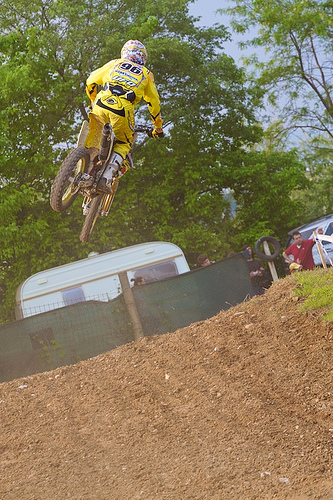

Prediction: man in blue shirt and helmet is doing tricks on his bike

Actual Description: dirt biker is taking large jump wearing yellow suit
Actual Description: man in yellow performs bike trick
Actual Description: motocross bike is jumping through the air over dirt track
Actual Description: person wearing yellow is taking jump on dirt bike
Actual Description: the motorcycle racer in yellow uniform is in midair


In [ ]:
# OBSERVATION OF PERFORMANCE ON RANDOM IMAGES FROM DEV DATASET
key = "3507670136_2e5f94accf"
print("Inception Model")
print(key)
feature_vec = dev_features[key].reshape((1, 2048))
display(Image(filename = dataset_root_path + "Flickr8k_Dataset/Flicker8k_Dataset/" + key + ".jpg"))
print("Prediction: {}".format(predict(feature_vec)))
print()
for caption in dev_dataset[key]:
    caption = " ".join(caption.split()[1:-1])
    print("Actual Description: {}".format(caption))

Inception Model
2431120202_b24fe2333a


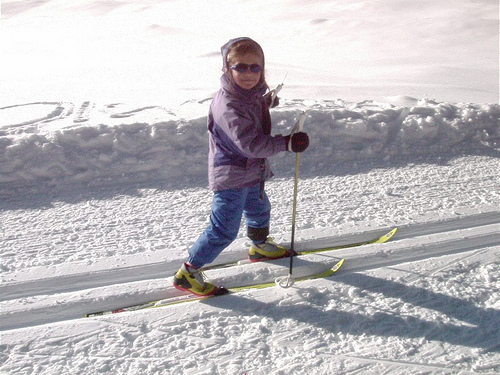

Prediction: man in red jacket snowboarding

Actual Description: girl crosscountry skis
Actual Description: girl on skis in snow
Actual Description: little girl wearing purple winter coat and sunglasses skiing in the snow
Actual Description: little girl on skis
Actual Description: the young girl is crosscountry skiing


In [ ]:
# OBSERVATION OF PERFORMANCE ON RANDOM IMAGES FROM DEV DATASET
key = "2431120202_b24fe2333a"
print("Inception Model")
print(key)
feature_vec = dev_features[key].reshape((1, 2048))
display(Image(filename = dataset_root_path + "Flickr8k_Dataset/Flicker8k_Dataset/" + key + ".jpg"))
print("Prediction: {}".format(predict(feature_vec)))
print()
for caption in dev_dataset[key]:
    caption = " ".join(caption.split()[1:-1])
    print("Actual Description: {}".format(caption))

Inception Model
241346105_c1c860db0d


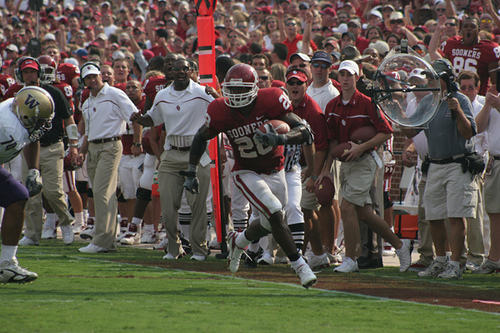

Prediction: football player in red and white uniform is running with football in the middle of the field

Actual Description: college football game is in progress
Actual Description: football player runs along the sidelines with football as crowd watches
Actual Description: an american footballer in red strip is running down the side of the field with the ball
Actual Description: the football player is running with football trying to score
Actual Description: the football player is trying to outrun his opponent


In [ ]:
# OBSERVATION OF PERFORMANCE ON RANDOM IMAGES FROM DEV DATASET
key = "241346105_c1c860db0d"
print("Inception Model")
print(key)
feature_vec = dev_features[key].reshape((1, 2048))
display(Image(filename = dataset_root_path + "Flickr8k_Dataset/Flicker8k_Dataset/" + key + ".jpg"))
print("Prediction: {}".format(predict(feature_vec)))
print()
for caption in dev_dataset[key]:
    caption = " ".join(caption.split()[1:-1])
    print("Actual Description: {}".format(caption))

Inception Model
537222436_ab406234ce


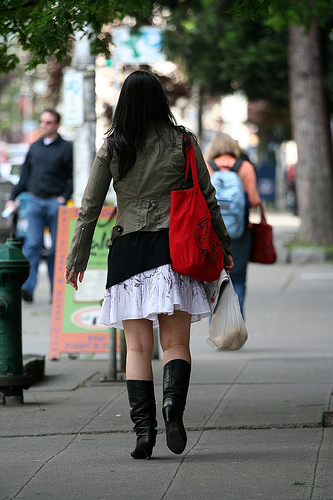

Prediction: woman in red sweater and black sweater walks down the street

Actual Description: black haired woman in white skirt and black boots is carrying red bag and walking down the street
Actual Description: short girl in white skirt black boots and graygreen jacket carrying red bag on the sidewalk
Actual Description: woman dressed up walks down the sidewalk with her back turned
Actual Description: woman in skirt and boots with red bag walking down the sidewalk
Actual Description: woman with short white skirt black boots and red bag walks away


In [ ]:
# OBSERVATION OF PERFORMANCE ON RANDOM IMAGES FROM DEV DATASET
key = "537222436_ab406234ce"
print("Inception Model")
print(key)
feature_vec = dev_features[key].reshape((1, 2048))
display(Image(filename = dataset_root_path + "Flickr8k_Dataset/Flicker8k_Dataset/" + key + ".jpg"))
print("Prediction: {}".format(predict(feature_vec)))
print()
for caption in dev_dataset[key]:
    caption = " ".join(caption.split()[1:-1])
    print("Actual Description: {}".format(caption))

Inception Model
3278581900_8ce75a5332


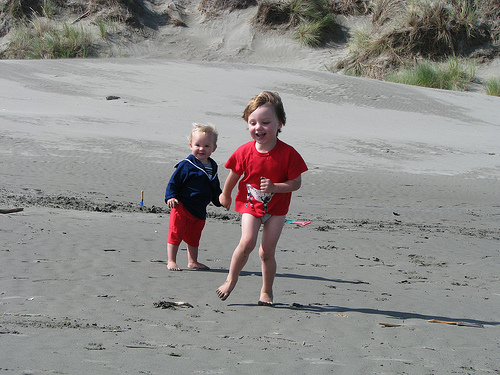

Prediction: young boy running on beach

Actual Description: toddler boy in sailor suit and little girl run in the sand
Actual Description: two kids run through grey sand
Actual Description: two small children walk down sandy beach
Actual Description: two smiling kids walking on sand
Actual Description: two young children are on sand


In [ ]:
# OBSERVATION OF PERFORMANCE ON RANDOM IMAGES FROM DEV DATASET
key = "3278581900_8ce75a5332"
print("Inception Model")
print(key)
feature_vec = dev_features[key].reshape((1, 2048))
display(Image(filename = dataset_root_path + "Flickr8k_Dataset/Flicker8k_Dataset/" + key + ".jpg"))
print("Prediction: {}".format(predict(feature_vec)))
print()
for caption in dev_dataset[key]:
    caption = " ".join(caption.split()[1:-1])
    print("Actual Description: {}".format(caption))

Inception Model
2600386812_8790879d9a


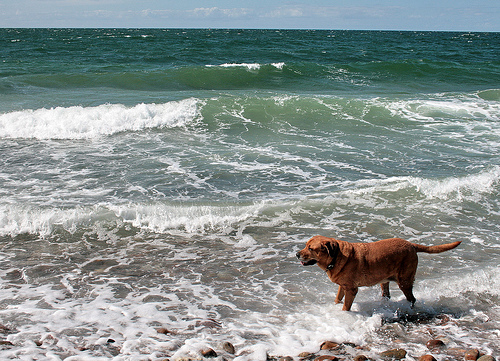

Prediction: dog is jumping into the water

Actual Description: brown dog is standing in the water watching the waves of the ocean on sunny day
Actual Description: brown dog steadies himself on the rocky shore of the ocean with several waves coming in
Actual Description: red dog stands in rocky shore its feet in the sea
Actual Description: the brown dog is in the waving water
Actual Description: the brown dog is standing on the beach as the waves lap up around its feet


In [ ]:
key = "2600386812_8790879d9a"
print("Inception Model")
print(key)
feature_vec = dev_features[key].reshape((1, 2048))
display(Image(filename = dataset_root_path + "Flickr8k_Dataset/Flicker8k_Dataset/" + key + ".jpg"))
print("Prediction: {}".format(predict(feature_vec)))
print()
for caption in dev_dataset[key]:
    caption = " ".join(caption.split()[1:-1])
    print("Actual Description: {}".format(caption))

Inception Model
2391812384_7429b5e567


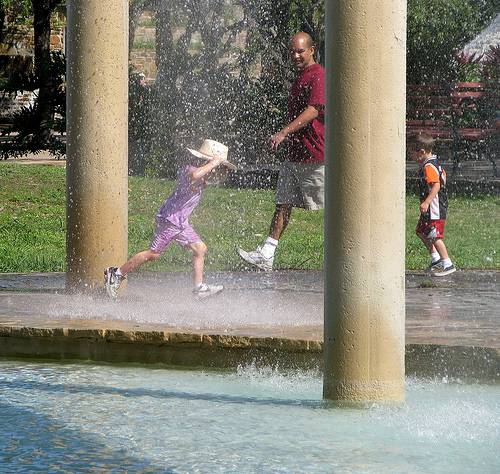

Prediction: child is jumping into swimming pool while another girl watches

Actual Description: child dressed in purple clothing and hat runs in splashing water while man and small boy walk nearby
Actual Description: child wearing purple runs through splashing water while man in red looks on
Actual Description: family playing the spray of fountain
Actual Description: man and two toddlers get sprinkled as they pass an ornamental fountain
Actual Description: young girl wearing purple running through water


In [ ]:
key = list(dev_dataset.keys())[np.random.randint(0, 1000)]
print("Inception Model")
print(key)
feature_vec = dev_features[key].reshape((1, 2048))
display(Image(filename = dataset_root_path + "Flickr8k_Dataset/Flicker8k_Dataset/" + key + ".jpg"))
print("Prediction: {}".format(predict(feature_vec)))
print()
for caption in dev_dataset[key]:
    caption = " ".join(caption.split()[1:-1])
    print("Actual Description: {}".format(caption))

Inception Model
2141713971_e25eb12712


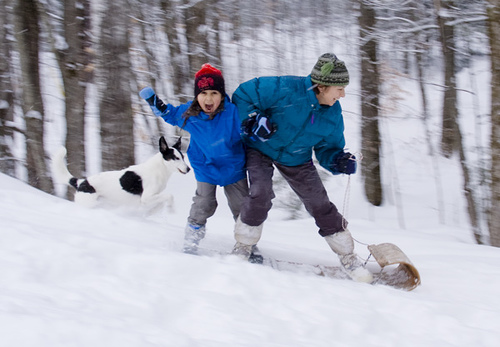

Prediction: two people are in the snow

Actual Description: woman and girl ride sled down hill standing up
Actual Description: woman and younger girl both wearing blue jackets and knit caps slide down hill on snow sled dog running at their side
Actual Description: woman and young girl riding sled down snowy hill while standing
Actual Description: woman and girl riding downhill on sled with dog running alongside them
Actual Description: two people on sled riding down snowy hill


In [ ]:
key = "2141713971_e25eb12712"
print("Inception Model")
print(key)
feature_vec = dev_features[key].reshape((1, 2048))
display(Image(filename = dataset_root_path + "Flickr8k_Dataset/Flicker8k_Dataset/" + key + ".jpg"))
print("Prediction: {}".format(predict(feature_vec)))
print()
for caption in dev_dataset[key]:
    caption = " ".join(caption.split()[1:-1])
    print("Actual Description: {}".format(caption))

Inception Model
1579206585_5ca6a24db0


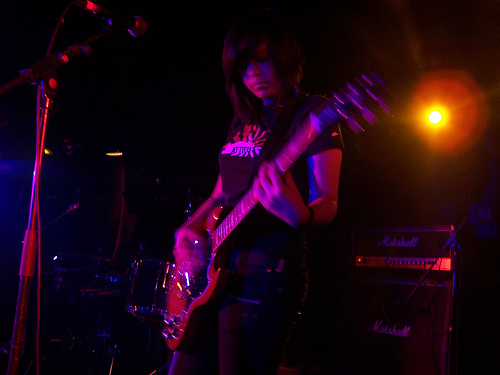

Prediction: man in white shirt and tie sings onstage onstage

Actual Description: girl is playing an electric guitar in front of an amplifier
Actual Description: girl plays her guitar on dark stage
Actual Description: woman is playing guitar onstage
Actual Description: woman playing guitar in red and blue light
Actual Description: guitar player performs at nightclub red guitar


In [ ]:
key ="1579206585_5ca6a24db0"
print("Inception Model")
print(key)
feature_vec = dev_features[key].reshape((1, 2048))
display(Image(filename = dataset_root_path + "Flickr8k_Dataset/Flicker8k_Dataset/" + key + ".jpg"))
print("Prediction: {}".format(predict(feature_vec)))
print()
for caption in dev_dataset[key]:
    caption = " ".join(caption.split()[1:-1])
    print("Actual Description: {}".format(caption))

Inception Model
2452686995_621878f561


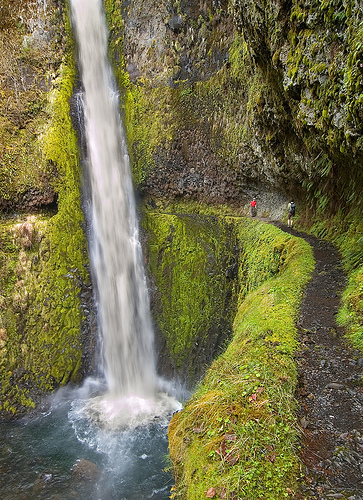

Prediction: man in red shirt climbs rock

Actual Description: beautiful waterfall with two people walking on the road beside it
Actual Description: beautiful waterfall flows down the side of mossy rock wall
Actual Description: waterfall cascades into shallow pool
Actual Description: waterfall splashes into pool at the bottom of steep grassy hill
Actual Description: two people travel down path going though woods with giant waterfall


In [ ]:
key = "2452686995_621878f561"
print("Inception Model")
print(key)
feature_vec = dev_features[key].reshape((1, 2048))
display(Image(filename = dataset_root_path + "Flickr8k_Dataset/Flicker8k_Dataset/" + key + ".jpg"))
print("Prediction: {}".format(predict(feature_vec)))
print()
for caption in dev_dataset[key]:
    caption = " ".join(caption.split()[1:-1])
    print("Actual Description: {}".format(caption))
    

Inception Model
2404520067_87798dbaee


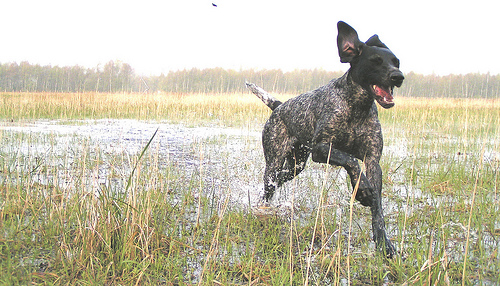

Prediction: black dog is running through the grass

Actual Description: black dog is running through swampy area with tall reeds
Actual Description: large dog runs through field in the rain
Actual Description: black dog runs through field in the rain
Actual Description: the dog runs through the field
Actual Description: the speckled dog runs through the marsh


In [ ]:
key = "2404520067_87798dbaee"
print("Inception Model")
print(key)
feature_vec = dev_features[key].reshape((1, 2048))
display(Image(filename = dataset_root_path + "Flickr8k_Dataset/Flicker8k_Dataset/" + key + ".jpg"))
print("Prediction: {}".format(predict(feature_vec)))
print()
for caption in dev_dataset[key]:
    caption = " ".join(caption.split()[1:-1])
    print("Actual Description: {}".format(caption))
    

Inception Model
3441145615_b4fcd9eea0


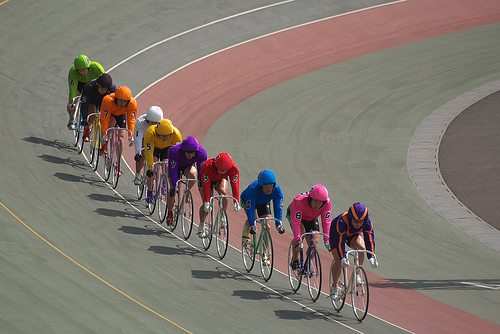

Prediction: group of people are riding bicycles on the street

Actual Description: group of cyclers race around track
Actual Description: group of people in colored outfits ride bikes around track
Actual Description: bicyclists stay in line as each wear different color suits
Actual Description: multiple bicyclists wearing different colored shirts and helmets riding around track
Actual Description: ten cyclists in different colors are racing around bend in the track


In [ ]:
key = "3441145615_b4fcd9eea0"
print("Inception Model")
print(key)
feature_vec = dev_features[key].reshape((1, 2048))
display(Image(filename = dataset_root_path + "Flickr8k_Dataset/Flicker8k_Dataset/" + key + ".jpg"))
print("Prediction: {}".format(predict(feature_vec)))
print()
for caption in dev_dataset[key]:
    caption = " ".join(caption.split()[1:-1])
    print("Actual Description: {}".format(caption))

Inception Model
3203878596_cbb307ce3b


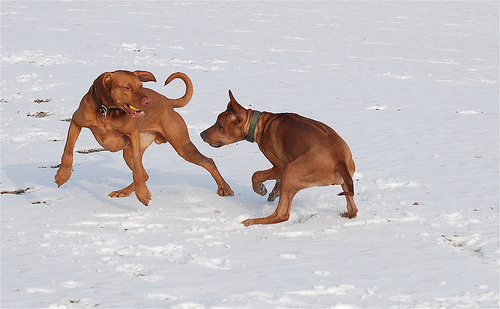

Prediction: two dogs are playing in the grass

Actual Description: two brown dogs are playing with each other in the snow
Actual Description: two brown dogs chase each other in the snow
Actual Description: two brown dogs play in the snow
Actual Description: two dogs playing in the snow
Actual Description: two dogs playing or fighting in the snow


In [ ]:
key = "3203878596_cbb307ce3b"
print("Inception Model")
print(key)
feature_vec = dev_features[key].reshape((1, 2048))
display(Image(filename = dataset_root_path + "Flickr8k_Dataset/Flicker8k_Dataset/" + key + ".jpg"))
print("Prediction: {}".format(predict(feature_vec)))
print()
for caption in dev_dataset[key]:
    caption = " ".join(caption.split()[1:-1])
    print("Actual Description: {}".format(caption))

Inception Model
2090545563_a4e66ec76b


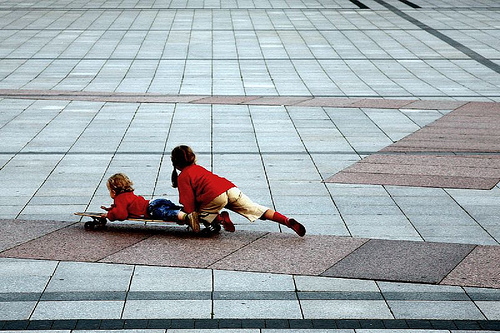

Prediction: two young boys are sitting on the ground near wooden door

Actual Description: the boy laying face down on skateboard is being pushed along the ground by another boy
Actual Description: two girls play on skateboard in courtyard
Actual Description: two people play on long skateboard
Actual Description: two small children in red shirts playing on skateboard
Actual Description: two young children on skateboard going across sidewalk


In [ ]:
key = "2090545563_a4e66ec76b"
print("Inception Model")
print(key)
feature_vec = dev_features[key].reshape((1, 2048))
display(Image(filename =dataset_root_path + "Flickr8k_Dataset/Flicker8k_Dataset/" + key + ".jpg"))
print("Prediction: {}".format(predict(feature_vec)))
print()
for caption in dev_dataset[key]:
    caption = " ".join(caption.split()[1:-1])
    print("Actual Description: {}".format(caption))

Inception Model
345785626_9fa59f38ce


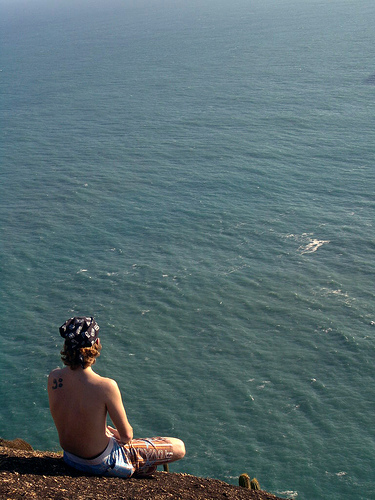

Prediction: man in swimming trunks is standing on the shore of body of water

Actual Description: lone man sitting on ledge that overlooks the beach
Actual Description: man sits on hill overlooking the ocean
Actual Description: man sits on the gravel by an ocean
Actual Description: young man sits on cliff watching the ocean
Actual Description: seated man looks out at the ocean


In [ ]:
key = "345785626_9fa59f38ce"
print("Inception Model")
print(key)
feature_vec = dev_features[key].reshape((1, 2048))
display(Image(filename =dataset_root_path + "Flickr8k_Dataset/Flicker8k_Dataset/" + key + ".jpg"))
print("Prediction: {}".format(predict(feature_vec)))
print()
for caption in dev_dataset[key]:
    caption = " ".join(caption.split()[1:-1])
    print("Actual Description: {}".format(caption))

Inception Model
3501936223_6122a13d27


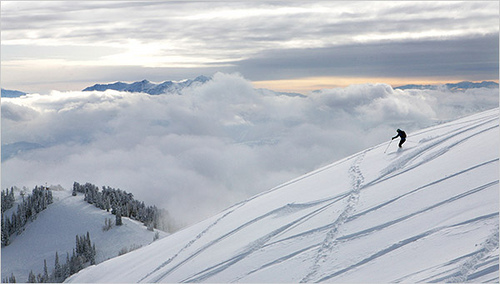

Prediction: man in red jacket is snowboarding

Actual Description: person skiing down very large snow covered mountain
Actual Description: skier is going down huge snow covered slope
Actual Description: skier skiing down large mountain
Actual Description: the man is skiing down the steep snowy white mountain with clouds in the background
Actual Description: the skier is going down large mountain


In [ ]:
key = list(dev_dataset.keys())[np.random.randint(0, 1000)]
print("Inception Model")
print(key)
feature_vec = dev_features[key].reshape((1, 2048))
display(Image(filename =dataset_root_path + "Flickr8k_Dataset/Flicker8k_Dataset/" + key + ".jpg"))
print("Prediction: {}".format(predict(feature_vec)))
print()
for caption in dev_dataset[key]:
    caption = " ".join(caption.split()[1:-1])
    print("Actual Description: {}".format(caption))

In [ ]:
model_test = InceptionV3(weights="imagenet")         #Loading model
  
  # re-structure the model
model_new = Model(inputs=model_test.inputs, outputs=model_test.layers[-2].output)

96124928/96112376 [==============================] - 1s 0us/step


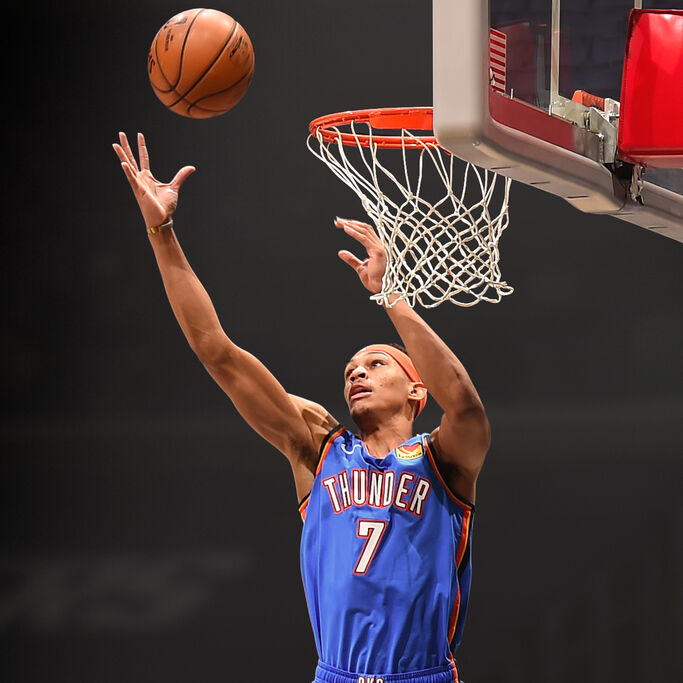

prediction: basketball player dribbles the ball


In [ ]:
# OBSERVATION OF PERFORMANCE ON RANDOM IMAGES INPUT FROM LOCAL MACHINE
def image_to_feature_vec(image_path):
    img = image.load_img(image_path, target_size = (299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    x = preprocess_input(x)
    feature_vec = model_new.predict(x)
    feature_vec = np.reshape(feature_vec, feature_vec.shape[1])
    return feature_vec.reshape((1, 2048))

image_path = "gdrive/MyDrive/Images/bask1.jpg"
feature_vec = image_to_feature_vec(image_path)
display(Image(filename = image_path))
print("prediction: {}".format(predict(feature_vec)))

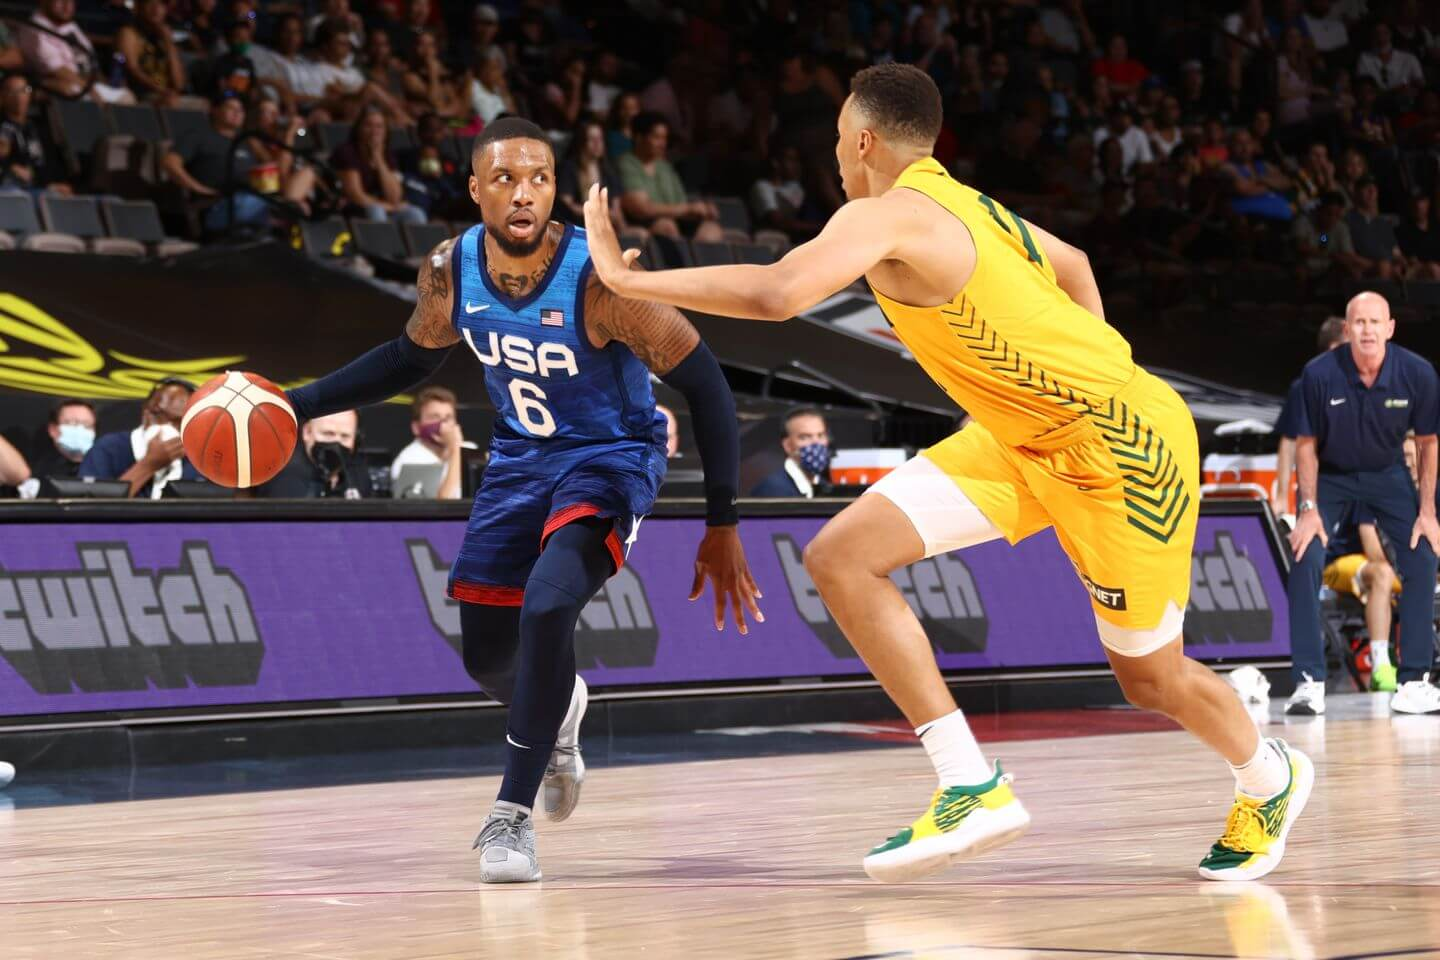

prediction: two men are playing basketball


In [ ]:
# OBSERVATION OF PERFORMANCE ON RANDOM IMAGES INPUT FROM LOCAL MACHINE
def image_to_feature_vec(image_path):
    img = image.load_img(image_path, target_size = (299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    x = preprocess_input(x)
    feature_vec = model_new.predict(x)
    feature_vec = np.reshape(feature_vec, feature_vec.shape[1])
    return feature_vec.reshape((1, 2048))

image_path = "gdrive/MyDrive/Images/drible.jpg"
feature_vec = image_to_feature_vec(image_path)
display(Image(filename = image_path))
print("prediction: {}".format(predict(feature_vec)))

In [ ]:
# OBSERVATION OF PERFORMANCE ON RANDOM IMAGES INPUT FROM LOCAL MACHINE
def image_to_feature_vec(image_path):
    img = image.load_img(image_path, target_size = (299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    x = preprocess_input(x)
    feature_vec = model_new.predict(x)
    feature_vec = np.reshape(feature_vec, feature_vec.shape[1])
    return feature_vec.reshape((1, 2048))

image_path = "gdrive/MyDrive/Images/jerry2.jpeg"
feature_vec = image_to_feature_vec(image_path)
display(Image(filename = image_path))
print("prediction: {}".format(predict(feature_vec)))

In [ ]:
key = list(dev_dataset.keys())[np.random.randint(0, 1000)]
print("Inception Model")
print(key)
feature_vec = dev_features[key].reshape((1, 2048))
display(Image(filename = dataset_root_path + "Flickr8k_Dataset/Flicker8k_Dataset/" + key + ".jpg"))
print("Prediction: {}".format(predict(feature_vec)))
print()
for caption in dev_dataset[key]:
    caption = " ".join(caption.split()[1:-1])
    print("Actual Description: {}".format(caption))

In [ ]:
key = list(dev_dataset.keys())[np.random.randint(0, 1000)]
print("Inception Model")
print(key)
feature_vec = dev_features[key].reshape((1, 2048))
display(Image(filename = dataset_root_path + "Flickr8k_Dataset/Flicker8k_Dataset/" + key + ".jpg"))
print("Prediction: {}".format(predict(feature_vec)))
print()
for caption in dev_dataset[key]:
    caption = " ".join(caption.split()[1:-1])
    print("Actual Description: {}".format(caption))

In [ ]:
key = list(dev_dataset.keys())[np.random.randint(0, 1000)]
print("Inception Model")
print(key)
feature_vec = dev_features[key].reshape((1, 2048))
display(Image(filename = dataset_root_path + "Flickr8k_Dataset/Flicker8k_Dataset/" + key + ".jpg"))
print("Prediction: {}".format(predict(feature_vec)))
print()
for caption in dev_dataset[key]:
    caption = " ".join(caption.split()[1:-1])
    print("Actual Description: {}".format(caption))

In [ ]:
# PERFORMANCE ON TRAIN DATASET, DEV DATASET, TEST DATASET
batch_size = 3
steps = len(train_dataset) // batch_size
train_generator = data_generator(batch_size,train_dataset, features, most_probable_vocabulary, max_caption_length)
train_performance = model.evaluate(train_generator, steps = steps, verbose = 0)

batch_size = 4
steps = len(dev_dataset) // batch_size
dev_generator = data_generator(batch_size,dev_dataset, dev_features, most_probable_vocabulary, max_caption_length)
dev_performance = model.evaluate(dev_generator, steps = steps, verbose = 0)

print("LOSS ON TRAIN DATASET: {}".format(train_performance))
print("LOSS ON DEV DATASET: {}".format(dev_performance))

In [ ]:
# PERFORMANCE ON TRAIN DATASET, DEV DATASET, TEST DATASET
batch_size = 3
steps = len(train_dataset) // batch_size
train_generator = data_generator(batch_size,train_dataset, train_features, most_probable_vocabulary, max_caption_length)
train_performance = load_saved_final_model.evaluate(train_generator, steps = steps, verbose = 0)

batch_size = 4
steps = len(dev_dataset) // batch_size
dev_generator = data_generator(batch_size,dev_dataset, dev_features, most_probable_vocabulary, max_caption_length)
dev_performance = load_saved_final_model.evaluate(dev_generator, steps = steps, verbose = 0)

print("LOSS ON TRAIN DATASET: {}".format(train_performance))
print("LOSS ON DEV DATASET: {}".format(dev_performance))